In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import re
import torch
import warnings
import logging

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category = UserWarning)

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
kaggle_test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("\nBelow is the training data:\n")
train_df


Below is the training data:



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1



1743 tweets in the training data contain hashtag

3971 tweets in the training data contain URL

2009 tweets in the training data contain mentions


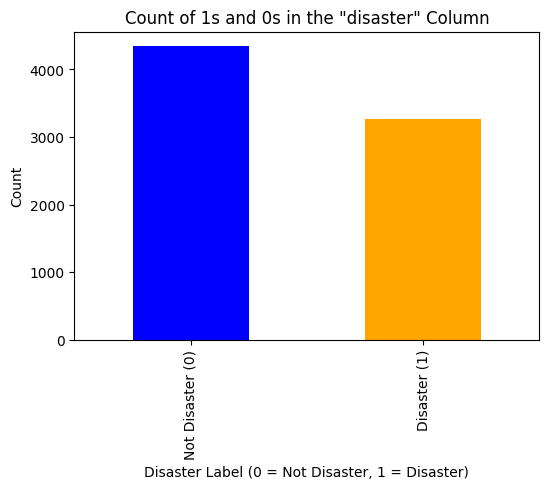

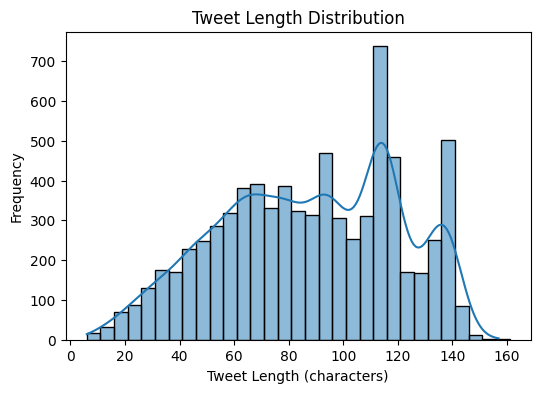

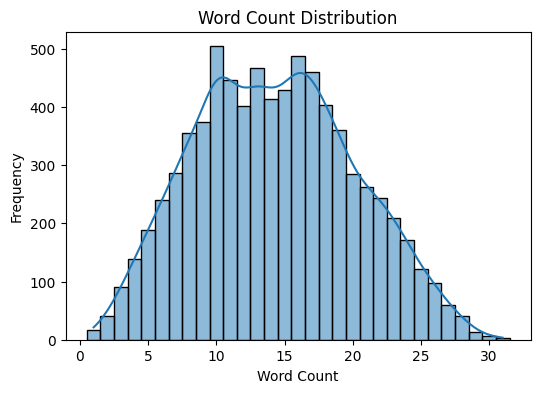

In [2]:
'''
Data pre-processing
'''
hashtag_count = 0
url_count = 0
mentions_count = 0

for tweet in train_df['text']:
    
    if re.search(r'#\w+', tweet):
        hashtag_count += 1
    
   
    if re.search(r'http\S+', tweet):
        url_count += 1
        
    if re.search(r'@\w+', tweet):
        mentions_count += 1

print("\n{} tweets in the training data contain hashtag".format(hashtag_count))
print("\n{} tweets in the training data contain URL".format(url_count))
print("\n{} tweets in the training data contain mentions".format(mentions_count))

processed_train_df = train_df.copy()

for i in range(len(processed_train_df)):
    
    processed_train_df.loc[i,'text'] = re.sub(r'http\S+|www\S+|https\S+', '', processed_train_df.loc[i,'text']) #Removing URLs as they might not be useful

#Plotting the class distribution in the target
plt.figure(figsize=(6, 4))
processed_train_df['target'].value_counts().plot(kind='bar', color=['blue', 'orange'])

plt.title('Count of 1s and 0s in the "disaster" Column')
plt.xlabel('Disaster Label (0 = Not Disaster, 1 = Disaster)')
plt.ylabel('Count')

plt.xticks([0, 1], ['Not Disaster (0)', 'Disaster (1)'])  # Label x-axis
plt.show()

#Plotting the distribution of tweet length
plt.figure(figsize=(6, 4))
processed_train_df['tweet_length'] = processed_train_df['text'].apply(len)

sns.histplot(processed_train_df['tweet_length'], binwidth=5, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()

#Plotting word count distribution of tweets
plt.figure(figsize=(6, 4))
processed_train_df['word_count'] = processed_train_df['text'].apply(lambda x: len(x.split()))

sns.histplot(processed_train_df['word_count'], discrete=True, kde=True)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

processed_train_df.drop(columns = ['tweet_length','word_count'], inplace = True)

In [3]:
'''
Fine-tuning a bert transformer model to predict disaster
'''
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

train_data_df, test_data_df = train_test_split(processed_train_df, test_size=0.2, random_state=42)

def tokenize_tweets(tweets, tokenizer, max_len=160):
    return tokenizer(tweets.tolist(),
                     padding=True,
                     truncation=True,
                     max_length=max_len,
                     return_tensors="pt")

# Tokenize the training and testing tweets
train_encodings = tokenize_tweets(train_data_df['text'], tokenizer)
test_encodings = tokenize_tweets(test_data_df['text'], tokenizer)

# Convert targets to tensor
train_labels = torch.tensor(train_data_df['target'].values)
test_labels = torch.tensor(test_data_df['target'].values)

# Create TensorDatasets for PyTorch DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Set up the optimizer and scheduler
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=1e-5)

scheduler = get_scheduler("linear",
                          optimizer=optimizer,
                          num_warmup_steps=int((len(train_loader) // BATCH_SIZE) * 0.1),
                          num_training_steps=len(train_loader) * EPOCHS)

# Define the training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
    scheduler.step()

    return total_loss / len(data_loader)

# Define evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Training the model

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}")

    accuracy = eval_model(model, test_loader, device)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_bert_disaster")
tokenizer.save_pretrained("./fine_tuned_bert_disaster")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 191/191 [01:18<00:00,  2.44it/s]


Epoch 1/5, Train Loss: 0.5012
Test Accuracy: 84.11%


100%|██████████| 191/191 [01:23<00:00,  2.29it/s]


Epoch 2/5, Train Loss: 0.3663
Test Accuracy: 84.83%


100%|██████████| 191/191 [01:23<00:00,  2.28it/s]


Epoch 3/5, Train Loss: 0.3114
Test Accuracy: 83.26%


100%|██████████| 191/191 [01:23<00:00,  2.29it/s]


Epoch 4/5, Train Loss: 0.2515
Test Accuracy: 81.16%


100%|██████████| 191/191 [01:24<00:00,  2.27it/s]


Epoch 5/5, Train Loss: 0.1967
Test Accuracy: 82.93%


('./fine_tuned_bert_disaster/tokenizer_config.json',
 './fine_tuned_bert_disaster/special_tokens_map.json',
 './fine_tuned_bert_disaster/vocab.txt',
 './fine_tuned_bert_disaster/added_tokens.json',
 './fine_tuned_bert_disaster/tokenizer.json')

In [4]:
'''
Predicting if a tweet is about a diasater on kaggle test dataset 
'''

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_bert_disaster")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_bert_disaster")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize the test tweets
kaggle_test_encodings = tokenizer(kaggle_test_df['text'].tolist(),
                                  padding=True,
                                  truncation=True,
                                  max_length=160,
                                  return_tensors="pt")

# Set model to evaluation mode
model.eval()

# Prepare input data
input_ids = kaggle_test_encodings['input_ids'].to(device)
attention_mask = kaggle_test_encodings['attention_mask'].to(device)


# Make predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to list
predicted_labels = predictions.cpu().numpy()

submission_df = pd.DataFrame({'id': kaggle_test_df['id'],
                              'target': predicted_labels})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("\nBelow is the submission:")
print(submission_df)


Below is the submission:
         id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]
